In [1]:
from mlflow.tracking.client import MlflowClient
from mlflow.entities import ViewType
import mlflow
import pandas as pd
mlflow.set_tracking_uri('file:../mlruns')
mlflow.get_tracking_uri()
client = MlflowClient(tracking_uri='file:../mlruns')

In [2]:
experiment = client.get_experiment_by_name('continuous_1')

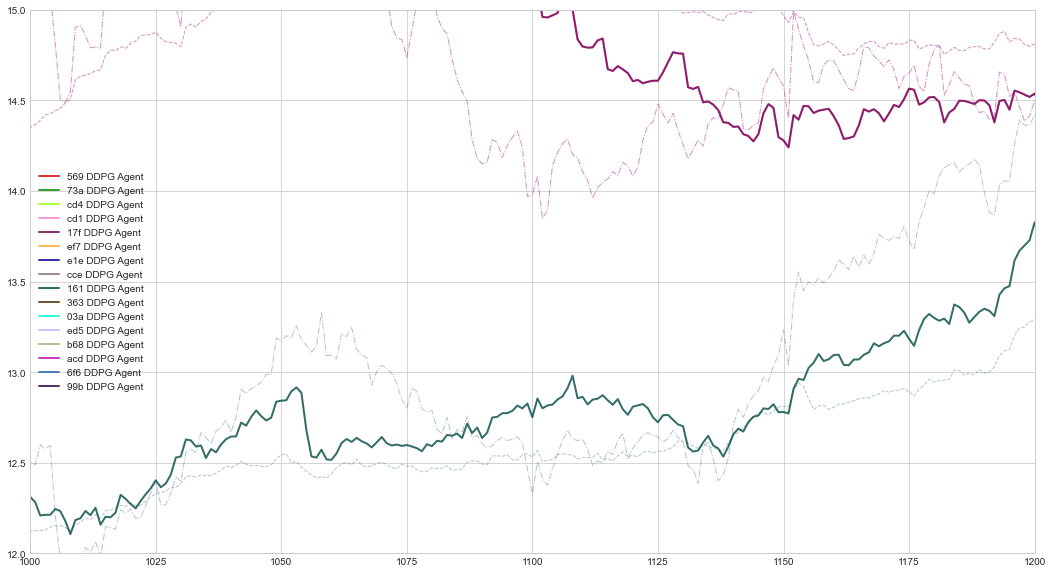

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mlflow.exceptions import MlflowException
import numpy as np
import colorcet as cc
plt.style.use("seaborn-whitegrid")

#mpl.rcParams['axes.grid'] = True
#mpl.rcParams['grid.linewidth'] = 0.1
#mpl.rcParams['grid.color'] = "000000"
#grid.color     : b0b0b0  ## grid color
#grid.linestyle : -       ## solid
#grid.linewidth : 0.8     ## in points
#grid.alpha     : 1.0     ## transparency, between 0.0 and 1.0
runs = client.search_runs(experiment_ids=experiment.experiment_id)
plt.figure(figsize=(18,10))
x_lim = 0
for i, run in enumerate(runs):
    try:
        score = pd.DataFrame([ dict(m) for m in client.get_metric_history(run_id=run.info.run_id, key='score')])
        color = cc.glasbey_bw[i % len(cc.glasbey_bw)]
        x_lim = max(x_lim, score.step.max())
        if score.step.max() > 2000 or score.value.max() <= 10:
            pass
        #plt.plot(score.step, score.value, linewidth=0.5, color=color, alpha=0.05)
        plt.plot(score.step, score.value.rolling(100, min_periods=1).mean(), 
                 linewidth=2, color=color, alpha=0.8, linestyle='-', 
                 label=f'{run.info.run_id[:3]} {run.data.tags["mlflow.runName"]}')
        plt.plot(score.step, score.value.rolling(200, min_periods=1).mean(), 
                 linewidth=1, color=color, alpha=0.3, linestyle='--')
        plt.plot(score.step, score.value.rolling(50, min_periods=1).mean(), 
                 linewidth=1, color=color, alpha=0.3, linestyle='-.')

        if run.data.params.get('is_solved', 'False') == 'True':
            step_solved = run.data.metrics['episodes_to_solve']
            score_avg = score.loc[score.step<=step_solved, 'value'].rolling(100).mean().iloc[-1]
            plt.plot(step_solved, score_avg, marker='X', markersize=15, color=color)
    except MlflowException:
        pass
plt.xlim([1000, 1200])
plt.ylim([12, 15])
plt.legend();

In [4]:
%matplotlib inline
from scipy import stats

runs = client.search_runs(experiment_ids=experiment.experiment_id)

x_lim = 0
for i, run in enumerate(runs):
    try:
        score = pd.DataFrame([ dict(m) for m in client.get_metric_history(run_id=run.info.run_id, key='score')])
        color = cc.glasbey_bw[i % len(cc.glasbey_bw)]
        x_lim = max(x_lim, score.step.max())
        avg_100 = score.value.rolling(100, min_periods=1).mean()
        std_100 = score.value.rolling(100, min_periods=1).std()
        plt.figure(figsize=(18,3))
        #plt.plot(score.step, score.value, linewidth=0.5, color=color, alpha=0.05)
        plt.fill_between(score.step, avg_100 - std_100,  avg_100 + std_100,
                 color=color, alpha=0.3)
        plt.plot(score.step, avg_100, 
                 linewidth=2, color=color, alpha=1, linestyle='-', 
                 label=f'{run.info.run_id[:3]} {run.data.tags["mlflow.runName"]}')

        if run.data.params.get('is_solved', 'False') == 'True':
            step_solved = run.data.metrics['episodes_to_solve']
            score_avg = avg_100.loc[score.step<=step_solved].iloc[-1]
            plt.plot(step_solved, score_avg, marker='X', markersize=15, color=color)
        score_avg = score.loc[score.step<=step_solved, 'value'].rolling(100).mean().iloc[-1]
        plt.plot(score.step.iloc[-1], avg_100.iloc[-1], marker='o', markersize=10, color=color)
        p_success = 1 - stats.norm(avg_100.iloc[-1], std_100.iloc[-1]).cdf(13)
        plt.title(f'{std_100.iloc[-1]:.2f} {(score.value.iloc[-100:] >= 13).sum()/100} {p_success}')
    except MlflowException:
        pass
    plt.xlim([0, 2000])
    plt.ylim([0, 25])
    plt.legend();

NameError: name 'cc' is not defined

In [5]:
uri = run.info.artifact_uri
import os
print(uri[7:])
os.listdir(uri[7:])

/mlruns_aws/1/5697050ac837453d95a752696307409f/artifacts


FileNotFoundError: [Errno 2] No such file or directory: '/mlruns_aws/1/5697050ac837453d95a752696307409f/artifacts'

In [397]:
runs = client.search_runs(experiment_ids=experiment.experiment_id)
for run in runs:
    mlflow.start_run(run_id=run.info.run_id)
    mlflow.end_run()